## DATA PREPROCESSING BLOCK ##

IMPORTING ALL THE NECESSARY PACKAGES

In [1]:
import nltk
import pandas as pd
import numpy as np
# The NLTK data package includes a pre-trained Punkt tokenizer for English.
# punkt had to be manually downloaded using the command below
# same with stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input, Concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model

tf.config.run_functions_eagerly(True)

The train, validation and test datasets are all available as different tsv files. We import them into 3 different Pandas dataframes, and then merge them together to the *original_df* dataframe.

In [4]:
df_train = pd.read_csv('/kaggle/input/translated-data-english/translated_data_english.tsv', sep='\t')
df_validation = pd.read_csv('/kaggle/input/translated-data-english-validation/translated_data_english_validation.tsv', sep='\t')
df_test = pd.read_csv('/kaggle/input/translated-data-english-test/translated_data_english_test.tsv', sep='\t')

In [5]:
original_df = pd.DataFrame()
original_df = original_df.append(df_train, ignore_index=True)
original_df = original_df.append(df_test, ignore_index=True)
original_df = original_df.append(df_validation, ignore_index=True)

/tmp/ipykernel_24/1249960246.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(df_train, ignore_index=True)
/tmp/ipykernel_24/1249960246.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(df_test, ignore_index=True)
/tmp/ipykernel_24/1249960246.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(df_validation, ignore_index=True)


Let's now get an overview of what the data looks like.

In [6]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,When did the decline of coal start It started ...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,When did the decline of coal begin? It began w...
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Hillary Clinton agrees with John McCain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,Hillary Clinton agreed with John McCain by vot...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,Health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,Health care reform legislation is likely to ma...
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,The economic turnaround started at the end of ...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"Towards the end of my tenure, the economic tra..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,The Chicago Bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,The Chicago Bears have had more starting quart...


In [7]:
original_df.shape

(12782, 17)

## DATA PRE-PROCESSING BLOCK ##

We are following a simple pre-processing pipeline for the data, wherein we do the following:
- Conversion to lowercase
- Punctuation removal
- Tokenization
- Stopword removal
- Lemmetization

The preprocessed data will be stored in the dataframe itself, under a new column.

In [8]:
# Conversion to lowercase
original_df['english_translation'] = original_df['english_translation'].str.lower()

In [9]:
# Function to remove punctuation marks
import string
def removepunctuation(sentence):
   new_text = sentence.replace("—", " ") # "—" in the text was not equivalent to "-" so we replcaed "—" with a space
   print 
  #iterate over every single character to see if it is a punctuation or not, and then concatenate them using "join"
   punctuationfree="".join([i for i in new_text if i not in string.punctuation])
   return punctuationfree

In [10]:
original_df["statement_removedpunctuation"] = original_df['english_translation'].apply(removepunctuation)

In [11]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...


statement_removed punctuation contains the 'statement' column, with lowercased characters and removed punctuation 

In [12]:
# word_tokenize is a module in the nltk package that tokenizes a sentence into its tokens.
original_df["english_translation_tokenized"] = original_df["statement_removedpunctuation"].apply(word_tokenize)

In [13]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation,english_translation_tokenized
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...,"[when, did, the, decline, of, coal, begin, it,..."
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...,"[hillary, clinton, agreed, with, john, mccain,..."
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...,"[health, care, reform, legislation, is, likely..."
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra...","[towards, the, end, of, my, tenure, the, econo..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...,"[the, chicago, bears, have, had, more, startin..."


A new column, english_translation_tokenized, is created and it contains the tokens generated from the sentence.

In [14]:
# store the list of stopwords in the stop_words variable
stop_words = stopwords.words('english')

In [15]:
# Function that removes stopwords from a corpus
def stopwordremoval(words):
    preprocessed_tokens = []
    for i in words:
        # Remove stopwords and empty strings while keeping words separated by space
        post_removal = [word for word in i.split() if word.lower() not in stop_words]
        filtered_string = " ".join(post_removal).strip()
        if filtered_string:
            preprocessed_tokens.append(filtered_string)
    # Combine the preprocessed tokens into a single string
    combined_string = " ".join(preprocessed_tokens)
    return combined_string

In [16]:
original_df["english_translation_stopwords"] = original_df["english_translation_tokenized"].apply(stopwordremoval)

In [17]:
nlp = spacy.load("en_core_web_sm")

In [18]:
def lemmetization(text):
    doc = nlp(text)
    lemmetized = []
    for token in doc:
        lemmetized.append(token.lemma_)
    return " ".join(lemmetized)

In [19]:
original_df["preprocessed_english"] = original_df["english_translation_stopwords"].apply(lemmetization)

## Target value pre-processing

We can see here that there are six labels for the dataset. However, the boundaries between them are pretty vague, and do not make a lot of sense when we talk about news from the real world.

In [20]:
original_df['label'].value_counts()

half-true      2626
false          2504
mostly-true    2453
barely-true    2101
true           2051
pants-fire     1047
Name: label, dtype: int64

So, we merged two features to make a single feature, thus resulting in a total of 3 target features, not 6.

In [21]:
original_df.replace(to_replace=["true", "mostly-true"],
           value="true", inplace=True)
original_df.replace(to_replace=["false", "pants-fire"],
           value="false", inplace=True)
original_df.replace(to_replace=["half-true", "barely-true"],
           value="vague", inplace=True)

In [22]:
original_df.value_counts('label')

label
vague    4727
true     4504
false    3551
dtype: int64

Now we can see that the labels have been updated

In [23]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation,english_translation_tokenized,english_translation_stopwords,preprocessed_english
0,10540.json,vague,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...,"[when, did, the, decline, of, coal, begin, it,...",decline coal begin began natural gas layoff be...,decline coal begin begin natural gas layoff be...
1,324.json,true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...,"[hillary, clinton, agreed, with, john, mccain,...",hillary clinton agreed john mccain voting give...,hillary clinton agree john mccain voting give ...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...,"[health, care, reform, legislation, is, likely...",health care reform legislation likely mandate ...,health care reform legislation likely mandate ...
3,9028.json,vague,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra...","[towards, the, end, of, my, tenure, the, econo...",towards end tenure economic transformation began,towards end tenure economic transformation begin
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...,"[the, chicago, bears, have, had, more, startin...",chicago bears starting quarterbacks past ten y...,chicago bear start quarterback past ten year t...


And there are now 3 values for 'label' instead of 6

In [24]:
original_df['label'].unique()

array(['vague', 'true', 'false'], dtype=object)

In [25]:
corpus = original_df['preprocessed_english'].copy()

Creating a corpus that only contains the preprocessed statements.

In [26]:
label = original_df['label'].copy()

In [27]:
voc_size = len(set(corpus))

Create one hot representation of the corpus

In [28]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [29]:
sent_length = 5000
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ...  5474 10420  6931]
 [    0     0     0 ...  9487  1934  3174]
 [    0     0     0 ... 11230  8616  9991]
 ...
 [    0     0     0 ...  9324  9565  6555]
 [    0     0     0 ...  9565 10725 11861]
 [    0     0     0 ...  8628  1452  7332]]


In [30]:
X_final=np.array(embedded_docs)
y_final=np.array(label)

In [31]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
ohe = OneHotEncoder()
# Fit and transform the target variable
# y_training = label_encoder.fit_transform(y_train)
y_training = ohe.fit_transform(y_final.reshape(-1,1)).todense()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_training, test_size=0.33)

In [33]:
X_train.shape

(8563, 5000)

In [34]:
y_train.shape

(8563, 3)

In [35]:
## Creating model
embedding_vector_features= 1000
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
#model.add(Dropout(0.5))
model.add(LSTM(20))
model.add(Dropout(0.3))
model.add(Dense(50, input_shape=(sent_length,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 1000)        12744000  
                                                                 
 lstm (LSTM)                 (None, 20)                81680     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 batch_normalization (BatchN  (None, 50)               200       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

In [36]:
history = model.fit(X_train,y_train,epochs=10, validation_split=0.2)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 53s 217ms/step - loss: 1.2384 - accuracy: 0.3436 - val_loss: 1.0868 - val_accuracy: 0.3789
Epoch 2/10
215/215 [==============================] - 48s 223ms/step - loss: 1.1290 - accuracy: 0.3756 - val_loss: 1.0804 - val_accuracy: 0.3917
Epoch 3/10
215/215 [==============================] - 47s 217ms/step - loss: 1.0808 - accuracy: 0.4231 - val_loss: 1.0738 - val_accuracy: 0.4086
Epoch 4/10
215/215 [==============================] - 48s 225ms/step - loss: 0.9919 - accuracy: 0.5101 - val_loss: 1.1695 - val_accuracy: 0.3940
Epoch 5/10
215/215 [==============================] - 48s 221ms/step - loss: 0.8865 - accuracy: 0.5933 - val_loss: 1.2689 - val_accuracy: 0.3870
Epoch 6/10
215/215 [==============================] - 48s 224ms/step - loss: 0.7651 - accuracy: 0.6728 - val_loss: 1.3942 - val_accuracy: 0.3847
Epoch 7/10
215/215 [==============================] - 48s 222ms/step - loss: 0.6534 - accuracy: 0.7312 - val_loss: 1.4625 - val_accuracy: 0.3

In [37]:
model.evaluate(X_test, y_test)

132/132 [==============================] - 10s 76ms/step - loss: 2.2831 - accuracy: 0.3835


[2.2831380367279053, 0.3835031986236572]

In [38]:
# Perform evaluation
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to labels

# Convert one-hot encoded target labels to labels
y_true_labels = np.argmax(y_test, axis=1)

132/132 [==============================] - 10s 72ms/step


In [39]:
# Create confusion matrix
confusion_mat = confusion_matrix(np.asarray(y_true_labels), y_pred_labels)

# Create pandas DataFrame from confusion matrix
labels = ['Label 1', 'Label 2', 'Label 3']  # Replace with your actual label names
confusion_df = pd.DataFrame(confusion_mat, index=labels, columns=labels)

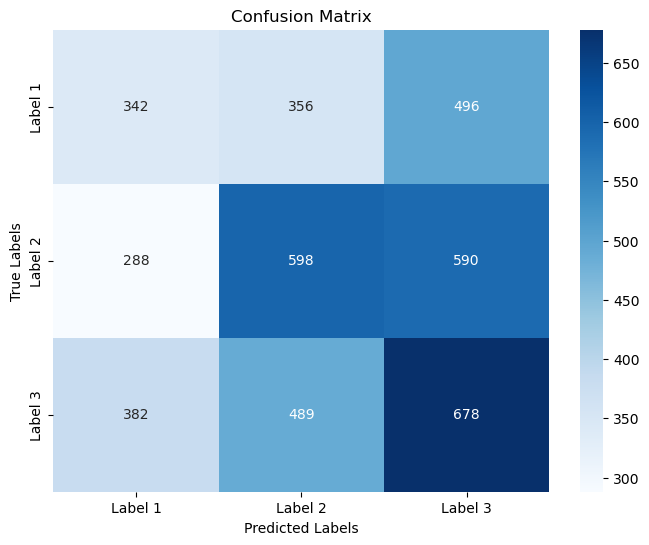

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

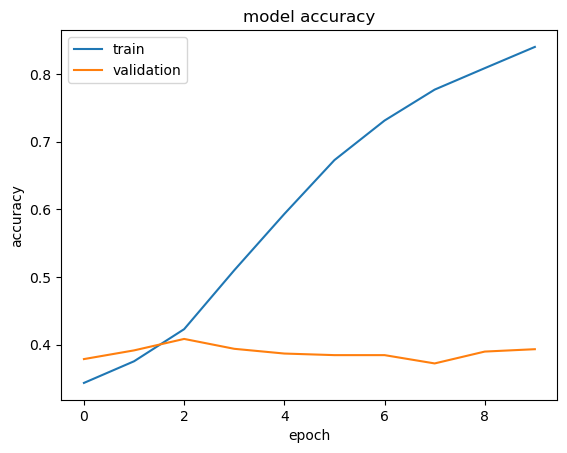

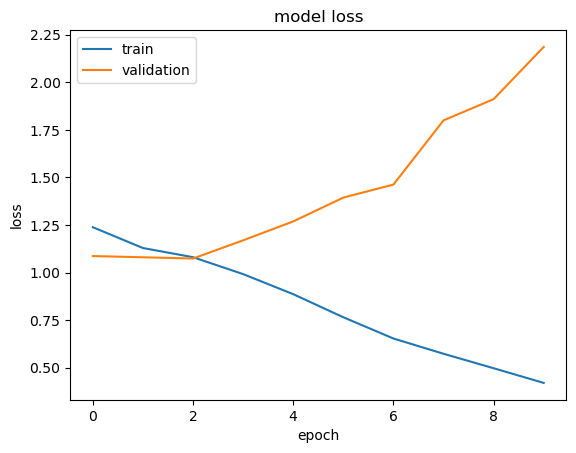

In [41]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
plot_history(history)

In [42]:
'''
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=X_train.shape[1]))  # Embedding layer
# model.add(Dropout(rate=0.4))
model.add(LSTM(units=4))
# model.add(Dropout(rate=0.4))
model.add(Dense(units=50,  activation='relu'))
# model.add(Dropout(rate=0.5))
model.add(Dense(units=3, activation='sigmoid'))

model.summary()


adam=tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=[X_valid, y_valid],
    batch_size=16,
    epochs = 5
)

'''

"\nvocab_size = 5000\n\nmodel = Sequential()\nmodel.add(Embedding(vocab_size, 128, input_length=X_train.shape[1]))  # Embedding layer\n# model.add(Dropout(rate=0.4))\nmodel.add(LSTM(units=4))\n# model.add(Dropout(rate=0.4))\nmodel.add(Dense(units=50,  activation='relu'))\n# model.add(Dropout(rate=0.5))\nmodel.add(Dense(units=3, activation='sigmoid'))\n\nmodel.summary()\n\n\nadam=tf.keras.optimizers.Adam(learning_rate=0.0001)\n\nmodel.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])\n\nhistory = model.fit(\n    X_train, \n    y_train, \n    validation_data=[X_valid, y_valid],\n    batch_size=16,\n    epochs = 5\n)\n\n"

# TODO: #
## Confusion matrix construction
## real world testing pipeline: create a function that takes in the input in Nepali and does everything necessary to return value for a label.

Findings, result analysis, data sources, etc explanation

In [43]:
!pip install deep_translator

In [44]:
from deep_translator import GoogleTranslator
def fake_news_tester(nepali_news):
    english_translation = GoogleTranslator(source='auto', target="en").translate(nepali_news)
    print(english_translation, "\n")
    english_translation_lower = english_translation.lower()
    english_tokenized = word_tokenize(english_translation_lower)
    print(english_tokenized, "\n")
    english_no_stopwords = stopwordremoval(english_tokenized)
    english_lemmetized = lemmetization(english_no_stopwords)
    print(english_lemmetized, "\n")
    onehot_text = one_hot(english_lemmetized, voc_size)
    sent_length = 5000
    input_embedded = pad_sequences([onehot_text],padding='pre',maxlen=sent_length)
    X_input = np.array(input_embedded)
    predictedlabely = model.predict(np.asarray(X_input))
    return ohe.inverse_transform(predictedlabely)

In [45]:
fake_news_tester("म्यानपावरवालाले श्रमिकलाई ठगेर कमाएको कालोधन सेतो बनाउँदै सरकार")

The government is making white the black money earned by manpowerwala by cheating the workers 

['the', 'government', 'is', 'making', 'white', 'the', 'black', 'money', 'earned', 'by', 'manpowerwala', 'by', 'cheating', 'the', 'workers'] 

government make white black money earn manpowerwala cheat worker 

1/1 [==============================] - 0s 100ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([['false']], dtype=object)

In [46]:
fake_news_tester("प्रधानमन्त्रीले आफ्नो दोस्रो हातमा मरुभूमि जित्ने योजना घोषणा गर्ने")

The Prime Minister will announce plans to conquer the desert with his second hand 

['the', 'prime', 'minister', 'will', 'announce', 'plans', 'to', 'conquer', 'the', 'desert', 'with', 'his', 'second', 'hand'] 

prime minister announce plan conquer desert second hand 

1/1 [==============================] - 0s 84ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([['true']], dtype=object)

In [47]:
fake_news_tester("संयुक्त राष्ट्रसँग नेपाललाई विश्वका प्रमुख परमाणु शक्ति बनाउने सम्झौता सम्पन्न")

An agreement was concluded with the United Nations to make Nepal the leading nuclear power in the world 

['an', 'agreement', 'was', 'concluded', 'with', 'the', 'united', 'nations', 'to', 'make', 'nepal', 'the', 'leading', 'nuclear', 'power', 'in', 'the', 'world'] 

agreement conclude united nations make nepal lead nuclear power world 

1/1 [==============================] - 0s 84ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([['false']], dtype=object)

In [48]:
fake_news_tester("नेपालका सरकारले खाडी बिषयमा विदेशी नीति अद्यावधिक गर्ने")

The government of Nepal will update its foreign policy on the Gulf 

['the', 'government', 'of', 'nepal', 'will', 'update', 'its', 'foreign', 'policy', 'on', 'the', 'gulf'] 

government nepal update foreign policy gulf 

1/1 [==============================] - 0s 80ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([['vague']], dtype=object)